##### The latest version of this IPython notebook is available at [http://github.com/jckantor/CBE40455](http://github.com/jckantor/CBE20255)  for noncommercial use under terms of the [Creative Commons Attribution Noncommericial ShareAlike License](http://creativecommons.org/licenses/by-nc-sa/4.0/).

J.C. Kantor (Kantor.1@nd.edu)

# Stochastic Price Models

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import datetime
from pandas_datareader import data, wb

import requests

def get_symbol(symbol):
    url = "http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={}&region=1&lang=en".format(symbol)
    result = requests.get(url).json()
    for x in result['ResultSet']['Result']:
        if x['symbol'] == symbol:
            return x['name']

## Statistical Properties of Returns

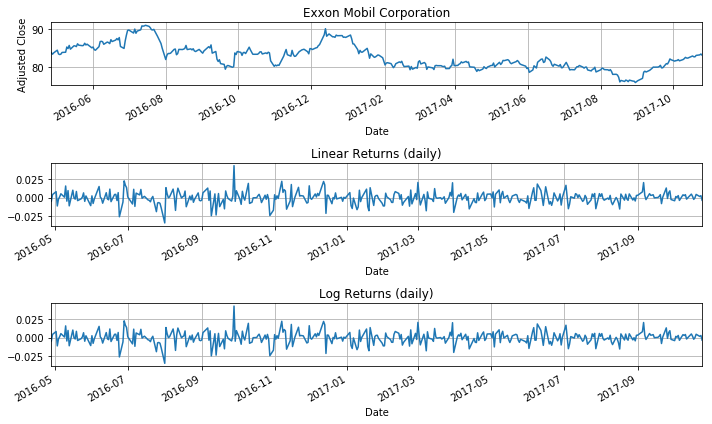

In [22]:
symbol = 'XOM'

# end date is today
end = datetime.datetime.today().date()

# start date is three years prior
start = end-datetime.timedelta(1.5*365)

# get stock price data
S = data.DataReader(symbol,"yahoo",start,end)['Adj Close']
rlin = (S - S.shift(1))/S.shift(1)
rlog = np.log(S/S.shift(1))

rlin = rlin.dropna()
rlog = rlog.dropna()

# plot data
plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
S.plot(title=get_symbol(symbol))
plt.ylabel('Adjusted Close')
plt.grid()

plt.subplot(3,1,2)
rlin.plot()
plt.title('Linear Returns (daily)')
plt.grid()
plt.tight_layout()

plt.subplot(3,1,3)
rlog.plot()
plt.title('Log Returns (daily)')
plt.grid()
plt.tight_layout()

### Distribution of Returns

A basic assumption in developing developing stochastic price models is that the residuals are indepdendent and identically distributed (i.i.d.) random variates.  Here we show the results of several common statistical tests that would screen out non-i.i.d. random variates.

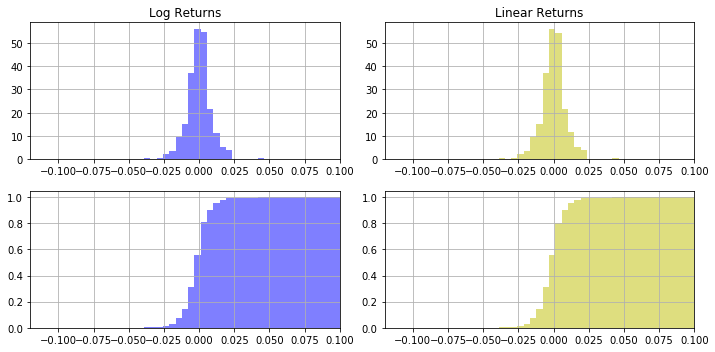

In [23]:
bins = np.linspace(-0.12,0.10,50)
plt.figure(figsize=(10,5))

plt.subplot(2,2,1)
rlog.hist(bins=bins, normed=True, color='b', alpha=0.5)
plt.xlim(bins.min(),bins.max())
plt.title('Log Returns')

plt.subplot(2,2,3)
rlog.hist(bins=bins, normed=True, cumulative=True, color='b',alpha=0.5)
plt.xlim(bins.min(),bins.max())

plt.subplot(2,2,2)
rlin.hist(bins=bins, normed=True, color='y', alpha=0.5)
plt.xlim(bins.min(),bins.max())
plt.title('Linear Returns')

plt.subplot(2,2,4)
rlin.hist(bins=bins, normed=True, cumulative=True, color='y',alpha=0.5)
plt.xlim(bins.min(),bins.max())

plt.tight_layout()

### Distribution of First Half versus Second Half of the Data Set

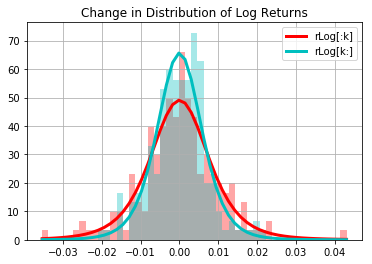

In [24]:
from scipy.stats import t

k = int(len(rlog)/2)
r = np.linspace(rlog.min(),rlog.max())

plt.figure();

param = t.fit(rlog[:k])
rlog[:k].hist(bins=r,normed=1,alpha=0.35,color='r')
plt.plot(r,t.pdf(r,df=param[0],loc=param[1],scale=param[2]),'r-',lw=3);

rlog[k:].hist(bins=r,normed=1,alpha=0.35,color='c')
param = t.fit(rlog[k:])
plt.plot(r,t.pdf(r,df=param[0],loc=param[1],scale=param[2]),'c-',lw=3);

plt.legend(['rLog[:k]','rLog[k:]'])
plt.title('Change in Distribution of Log Returns')

In [25]:
t.fit(rlog[:k].dropna())

(4.5753484075597921, 1.5449211864690811e-05, 0.0077030541214313112)

### Lag Plot of $r^{log}_{t+1}$ versus $r^{log}_t$

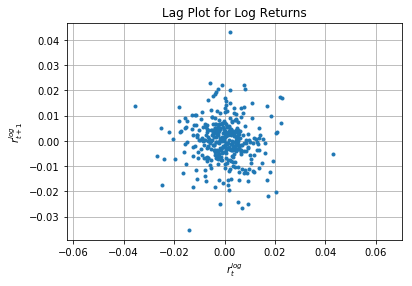

In [26]:
plt.plot(rlog[0:-1],rlog[1:],'.')
plt.axis('equal');
plt.xlabel('$r^{log}_{t}$')
plt.ylabel('$r^{log}_{t+1}$')
plt.grid()
plt.title('Lag Plot for Log Returns');

### Autocorrelation

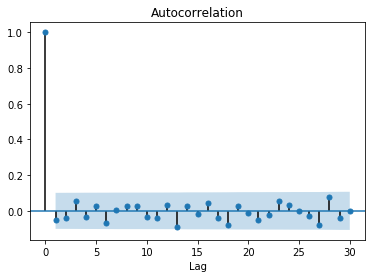

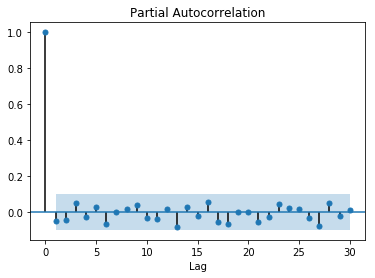

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(rlog,lags=min(30,len(rlog)));
plt.xlabel('Lag');
plot_pacf(rlog,lags=min(30,len(rlog)));
plt.xlabel('Lag');

## Price Forecasting using the Bootstrap

We have computed return as

$$r^{log}_{t} = \log \frac{S_{t+1}}{S_{t}} = \log R_t$$

$$r^{lin}_{t} = \frac{S_{t+1} - S_{t}}{S_{t}} = R_t - 1$$

and executed several tests of the hypothesis that $r^L_k$ behaves as independent, identically distributed (i.i.d.) random variable. If we're satisfied with this hypothesis, then we can randomly sample the historical return data $r^L_k$ to simulate future prices.  This bootstrap technique is relatively simple to implement as shown below.

In [28]:
from dateutil import rrule 
import datetime

def tradingDates(start_date=datetime.date.today(), 
                 end_date=datetime.date.today()+datetime.timedelta(days=92)):
    rs = rrule.rruleset()
    rs.rrule(rrule.rrule(rrule.DAILY, dtstart=start_date, until = end_date, 
                         byweekday=(rrule.MO,rrule.TU,rrule.WE,rrule.TH,rrule.FR)))
    rs.exdate(datetime.datetime(2015, 1,1))     # New Years Day
    rs.exdate(datetime.datetime(2015, 1,19))    # Martin Luther King Day
    rs.exdate(datetime.datetime(2015, 2,16))    # Washington's Birthday
    rs.exdate(datetime.datetime(2015, 4, 3))    # Good Friday
    rs.exdate(datetime.datetime(2015, 5,25))    # Memorial Day
    rs.exdate(datetime.datetime(2015, 7, 3))    # Independence Day
    rs.exdate(datetime.datetime(2015, 9, 7))    # Labor Day
    rs.exdate(datetime.datetime(2015,11,26))    # Thanksgiving Day
    rs.exdate(datetime.datetime(2015,12,25))    # Christmas Day
    rs.exdate(datetime.datetime(2016, 1, 1))    # New Years Day
    rs.exdate(datetime.datetime(2016, 1,18))    # Martin Luther King Day
    rs.exdate(datetime.datetime(2016, 2,15))    # Washington's Birthday
    rs.exdate(datetime.datetime(2016, 3,25))    # Good Friday
    rs.exdate(datetime.datetime(2016, 5,30))    # Memorial Day
    rs.exdate(datetime.datetime(2016, 7, 4))    # Independence Day
    rs.exdate(datetime.datetime(2016, 9, 5))    # Labor Day
    rs.exdate(datetime.datetime(2016,11,24))    # Thanksgiving Day
    rs.exdate(datetime.datetime(2016,12,26))    # Christmas Day
    return rs

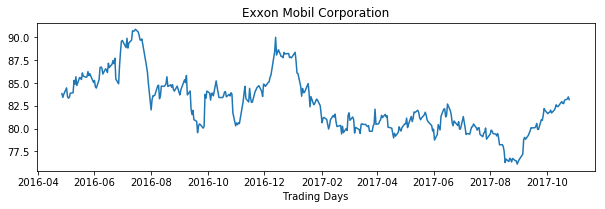

In [31]:
from scipy.stats import lognorm

N = 400
#start_date = S.index[-252]
start_date = S.index[-1]
end_date = datetime.date.today() + datetime.timedelta(days=365)

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)

plt.plot(S.index,S)
plt.title(get_symbol(symbol))
plt.xlabel('Trading Days')

# Initialize P using the last available price
P = np.array([S.ix[start_date]]*N)

In [32]:
# The generator returns one array of N random samples from the history of total returns
# for each t in the history of future horizon.
R = (S/S.shift(+1)).dropna()
R

Date
2016-04-28    0.995139
2016-04-29    1.004203
2016-05-02    1.008258
2016-05-03    0.988556
2016-05-04    0.998071
2016-05-05    1.001137
2016-05-06    1.005339
2016-05-09    1.000678
2016-05-10    1.016033
2016-05-11    0.995181
2016-05-12    1.009684
2016-05-13    0.988736
2016-05-16    1.010264
2016-05-17    0.999553
2016-05-18    0.997990
2016-05-19    1.008506
2016-05-20    0.995894
2016-05-23    0.998440
2016-05-24    1.000781
2016-05-25    1.006580
2016-05-26    0.994904
2016-05-27    1.002339
2016-05-31    0.989001
2016-06-01    1.002471
2016-06-02    0.992044
2016-06-03    0.998193
2016-06-06    1.010977
2016-06-07    1.015335
2016-06-08    1.000882
2016-06-09    0.998678
                ...   
2017-09-14    1.004012
2017-09-15    0.999750
2017-09-18    1.000250
2017-09-19    1.001623
2017-09-20    1.004114
2017-09-21    0.991806
2017-09-22    1.000376
2017-09-25    1.013263
2017-09-26    0.998889
2017-09-27    1.006676
2017-09-28    1.009333
2017-09-29    0.997445
2017-1

In [33]:
R = R.ix[0:start_date]

/Users/jeff/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


TypeError: cannot do slice indexing on <class 'pandas.core.indexes.datetimes.DatetimeIndex'> with these indexers [0] of <class 'int'>

/Users/jeff/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.path.
/Users/jeff/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/jeff/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


NameError: name 'xrange' is not defined

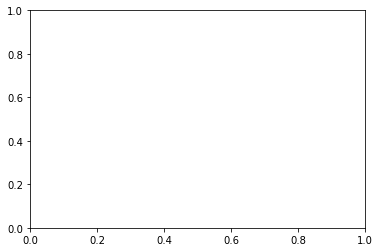

In [34]:
Zgenerator = ((d,np.array([np.random.choice(R) for _ in xrange(N)])) 
                for d in tradingDates(start_date,end_date))

plt.hold(True)

for d,Z in Zgenerator:
    P *= Z
    plt.plot([d]*N,P,'r.',ms=0.1,alpha=0.6)
    plt.plot(d,np.percentile(P,50),'g.',ms=1,alpha=0.6)
    plt.plot(d,np.percentile(P,2.5),'g.',ms=0.75,alpha=0.6)
    plt.plot(d,np.percentile(P,97.5),'g.',ms=0.75,alpha=0.6)
    
plt.hold(False)
plt.grid()
plt.ylim(0,plt.ylim()[1])

# Histogram

plt.subplot(2,2,3)
nbins = min(100,int(1.5*np.sqrt(N)))
plt.hist(P,bins=nbins,normed=1,alpha=0.35,color='b');

plt.hold(True)
shape,loc,scale = lognorm.fit(P,floc=0)
x=np.linspace(0,max(P),100)
pdf_fitted = lognorm.pdf(x, shape, loc=loc, scale=scale) # fitted distribution
plt.plot(x,pdf_fitted,'b-',lw=3)
p = np.mean(P)
ylim = plt.ylim()
plt.plot([p,p],ylim,'r--',lw=2)
plt.ylim(ylim)
plt.text(p,0.97*ylim[1],"  Mean = {0:.2f}".format(p),va = 'top')
plt.hold(False)

plt.xlim(min(P),max(P))
plt.xlabel('Final Price')
plt.ylabel('Probability');
plt.title("Price Distribution for {1}".format(description,d.strftime("%b %d %Y")))

# Cumulative Distribution

plt.subplot(2,2,4)
nbins = min(100,int(1.5*np.sqrt(N)))
plt.hist(P,bins=nbins,normed=1,cumulative=True,alpha=0.35,color='b');
plt.xlim(min(P),max(P))
plt.xlabel('Final Price')
plt.ylabel('Probability');
plt.title("Cumulative Distribution for {1}".format(description,d.strftime("%b %d %Y")))

plt.hold(True)
xtext = min(P) + 0.05*(max(P)-min(P))

p = 0.025
x = np.percentile(P,100*p)
plt.text(xtext,p+0.02,'{0:.2f}'.format(x),ha='left')
plt.plot([0,x,x],[p,p,0],'r--',lw=2)

p = 0.50
x = np.percentile(P,100*p)
plt.text(xtext,p+0.02,'{0:.2f}'.format(x),ha='left')
plt.plot([0,x,x],[p,p,0],'r--',lw=2)

p = 0.975
x = np.percentile(P,100*p)
plt.text(xtext,p-0.02,'{0:.2f}'.format(x),ha='left',va='top')
plt.plot([0,x,x],[p,p,0],'r--',lw=2)

plt.hold(False)
plt.grid()
plt.tight_layout()

## Fitting Returns to a Distribution

### Normal Distribution

In [35]:
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot

r = np.linspace(rLog.min(),rLog.max())

plt.figure()
param = norm.fit(R)
rLog.hist(bins=int(1.5*np.sqrt(len(rLog))),normed=1,alpha=0.4)
plt.plot(r,norm.pdf(r,loc=param[0],scale=param[1]),'r-',lw=3)

plt.figure()
qqplot(R,line='q');

NameError: name 'rLog' is not defined

### t-Distribution

In [36]:
from scipy.stats import t
from statsmodels.graphics.gofplots import qqplot

r = np.linspace(rLog.min(),rLog.max())

plt.figure();
param = t.fit(rLog)
rLog.hist(bins=int(1.5*np.sqrt(len(rLog))),normed=1,alpha=0.4);
plt.plot(r,t.pdf(r,df=param[0],loc=param[1],scale=param[2]),'r-',lw=3);

plt.figure();
qqplot(R,dist=t,distargs=(param[0],), loc=param[1], scale=param[2], line='45');


NameError: name 'rLog' is not defined

## Geometric Brownian Motion

$$S_{k+1} = S_k + \alpha h S_k + \beta \sqrt{h} S_k Z_k$$

where $Z_k \sim N(0,1)$ and $h$ corresponds to a sampling period of 1 'trading day'. There are typically 252 trading days in a calendar year, 63 trading days in a quarter, and 21 trading days in a month.

Defining return as

$$r^S_{k} = \frac{S_k - S_{k-1}}{S_{k-1}} = \alpha h + \beta \sqrt{h} Z_k$$

then the statistical model for $R_k$ becomes

$$r^S_{k} = \alpha h + \beta \sqrt{h} Z_k$$

For the case of Geometric Brownian Motion the hypothesis is that $r^S_k$ is a random variable drawn from a the normal distribution $r^S_k \sim N(\alpha h, \beta\sqrt{h}$).

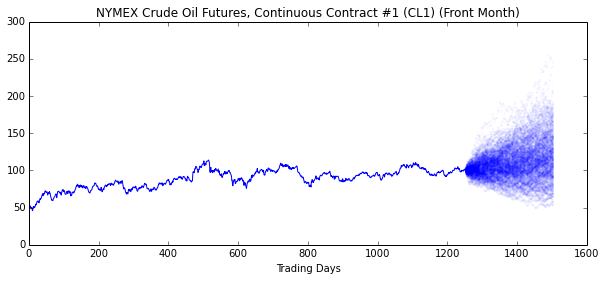

In [14]:
from scipy.stats import norm

figure(figsize=(10,4))
plot(S)
title(description)
xlabel('Trading Days')

N = 200    # number of realizations
T = 252    # simulation time horizon in trading days
h = 1      # time step in trading days

param = norm.fit(R)
alpha = param[0]/h
beta = param[1]/sqrt(h)

# Initialize P
P = array([S[-1]]*N)

# generator of random variates
Zgenerator = (array(norm.rvs(loc=alpha*h,scale=beta*sqrt(h),size=N)) for k in range(0,T))

k = len(S)
for Z in Zgenerator:
    k += 1
    P += P*Z
    plot([k]*N,P,'b.',ms=0.1)

### Forecast Assuming a Normal Distribution of Returns

0.287147332863 0 112.939532061


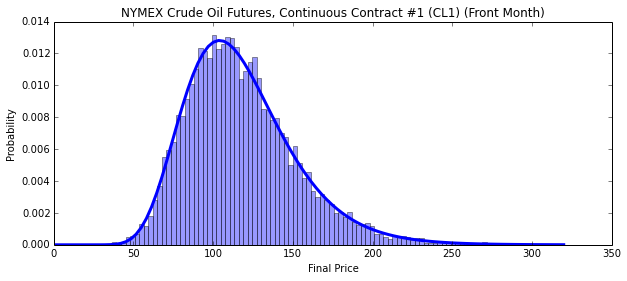

In [15]:
from scipy.stats import norm,lognorm

param = norm.fit(R)
alpha = param[0]
beta = param[1]

N = 10000
T = 252
h = 1

# Initialize P
Pgbm = array([S[-1]]*N)

# generator of random variates
Zgenerator = (array(norm.rvs(loc=alpha*h,scale=beta*sqrt(h),size=N)) for k in range(0,T))

for Z in Zgenerator:
    Pgbm += Pgbm*Z
    
figure(figsize=(10,4))
nbins = min(100,int(1.5*sqrt(N)))
hist(Pgbm,bins=nbins,normed=1,alpha=0.4,color='b');

shape,loc,scale = lognorm.fit(Pgbm,floc=0)
print shape,loc,scale
x=np.linspace(0,max(Pgbm),100)
pdf_fitted = lognorm.pdf(x, shape, loc=loc, scale=scale) # fitted distribution
plot(x,pdf_fitted,'b-',lw=3)
xlabel('Final Price')
ylabel('Probability');
title(description)

### Forecast Assuming a t-Distribution of Returns

0.292709661642 0 117.466994346


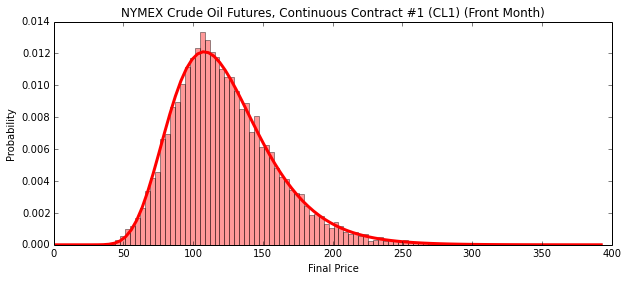

In [16]:
from scipy.stats import t,lognorm

param = t.fit(R)
df = param[0]
alpha = param[1]
beta = param[2]

N = 10000
T = 252
h = 1

# Initialize P
Pgtm = array([S[-1]]*N)

# generator of random variates
Zgenerator = (array(t.rvs(df,loc=alpha*h,scale=beta*sqrt(h),size=N)) for k in range(0,T))

for Z in Zgenerator:
    Pgtm += Pgtm*Z

figure(figsize=(10,4))
nbins = min(100,int(1.5*sqrt(N)))
hist(Pgtm,bins=nbins,normed=1,alpha=0.4,color='r');

shape,loc,scale = lognorm.fit(Pgtm,floc=0)
print shape,loc,scale
x=np.linspace(0,max(Pgtm),100)
pdf_fitted = lognorm.pdf(x, shape, loc=loc, scale=scale) # fitted distribution
plot(x,pdf_fitted,'r-',lw=3)
xlabel('Final Price')
ylabel('Probability');
title(description)

## Regressing Returns to Alternative Models

In [7]:
df = pd.DataFrame({'S':S,'R':R}, index = R.index)

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5004
Date:                Wed, 02 Apr 2014   Prob (F-statistic):              0.479
Time:                        18:35:38   Log-Likelihood:                 3236.8
No. Observations:                1251   AIC:                            -6470.
Df Residuals:                    1249   BIC:                            -6459.
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0098      0.015     -0.661      0.509        -0.039     0.019
LnS            0.0023      0.003      0.707      0.4

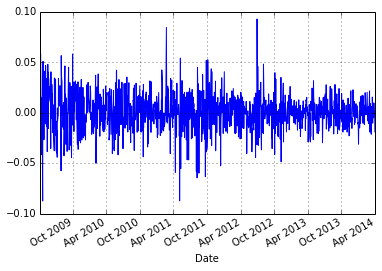

In [13]:
df = pd.DataFrame({'Price':S,'LnS':log(S),'Return':R})
df = df[~isnan(df['Return'])]
#plot(df['LnS'],df['Return'],'.')

import statsmodels.api as sm
df = sm.add_constant(df)
mod = sm.OLS(df['Return'],df[['const','LnS']])
res = mod.fit()
print res.summary()
print res.params
res.resid.plot()